# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip freeze > requirements.txt

In [2]:
!python -V

Python 3.6.3


In [3]:
!free

              total        used        free      shared  buff/cache   available
Mem:      131915260    23252980    16548016      214848    92114264   106034872
Swap:             0           0           0


In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, count, avg, sum as Fsum, approx_count_distinct, max, min, first
from pyspark.sql.types import IntegerType, FloatType, StringType
import datetime

import datetime
import time
import os
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1734538258138'),
 ('spark.driver.host',
  'f87c4adb2e3aa45f8b00eda7ba88dcd3ba532d2a-58ff7d7b6d-zbk2g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '39369'),
 ('spark.app.name', 'Sparkify Project')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# load in the dataset
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [9]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [11]:
print('Count of the dataset:', df.count())

Count of the dataset: 286500


### Check Missing Values

In [12]:
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [13]:
df.count()

286500

We see that the number of lines does not change.

### Check for duplicate userID

In [14]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



UserID contains empty values so need to filter to remove those rows

In [15]:
print('Number of rows with empty UserID:', df.filter(df["userId"] == "").count())

Number of rows with empty UserID: 8346


In [16]:
# remove those with an empty string userId
df = df.filter(df["userId"] != "")

In [17]:
df.select("userId").distinct().count()

225

Similarly, we check with the SessionID column.

In [18]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [19]:
df.filter(df["sessionId"] == "").count()

0

The sessionId column is quite good and does not contain any null values.

In [20]:
print('How many rows are there after cleaning the data?', df.count())

How many rows are there after cleaning the data? 278154


In [21]:
# Convert data to pandas dataframe
df_pandas = df.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### How many users have confirmed service cancellation?

Determine the label of each user to see who churned based on the page column in the data

In [22]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



We see that there are multiple pages that users are directed to and the Cancellation Confirmation page is the page where the user confirms that they will cancel the service. Let's see how many users are directed to this page.

In [23]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [24]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



We will label churned users as 1 and not churned users as 0

In [25]:
churn_data = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

Add churn column to df

In [26]:
df = df.withColumn("churn", churn_data("page"))
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    L

In [27]:
df.select('churn').groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



Since users can be navigating to different pages at different times, a user can have both a churn status of 0 and a churn status of 1. 

In [28]:
# Count the number of states of each user
df_churn = (
    df.select(['userId', 'churn'])
      .dropDuplicates()
      .groupBy('userId')
      .count()
      .orderBy(F.col('count').desc())  # Sort descending by 'count' column
)

df_churn.show()

+------+-----+
|userId|count|
+------+-----+
|300001|    2|
|100022|    2|
|    18|    2|
|    29|    2|
|100025|    2|
|300007|    2|
|    70|    2|
|100021|    2|
|   125|    2|
|     3|    2|
|    28|    2|
|100006|    2|
|    54|    2|
|100005|    2|
|100007|    2|
|100014|    2|
|    51|    2|
|   101|    2|
|    73|    2|
|    87|    2|
+------+-----+
only showing top 20 rows



Calculate the cumulative total for each user over time to ensure each user has only 1 churn state.

In [29]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)


In [30]:
df = df.withColumn(
    "churn",
    F.sum("churn").over(windowval)
)

df.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|                null|Logged In| Darianna|     F|           34|Carpenter|     null| free|Bridgeport-Stamfo...|   PUT|     Logout|1538016340000|      187|                null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|    0|
|          Lily Allen|Logged In| Darianna|     F|           33|Carpenter|185.259

In [31]:
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [32]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [33]:
df_churn = df_churn.toPandas()

In [34]:
df_churn.head()

,churn,count
0,0,173
1,1,52


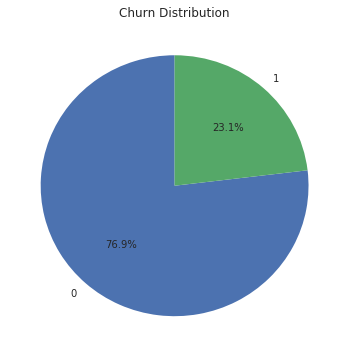

In [35]:
# Plotting the pie chart
df_churn.set_index('churn')['count'].plot.pie(
    autopct='%1.1f%%',  # Display percentages with 1 decimal point
    startangle=90,      # Rotate the pie chart to start at 90 degrees
    figsize=(6, 6),     # Set the figure size
    title='Churn Distribution'  # Add a title
)

# Display the plot
plt.ylabel('')  # Remove y-axis label for better visual
plt.savefig('churn_distribution.png')


!['Churn Distribution](churn_distribution.png)
From the chart above we can see that more than 23% of users churned (53 users).

#### How does user listening time influence churn?

In [36]:
df_length = df.filter(df['length'] != "NaN")

In [37]:
df_length = df_length.toPandas()
df_length.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,Hot Chip,Logged In,Darianna,F,29,Carpenter,319.42485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Alley Cats,200,1542823248000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Eminem,Logged In,Darianna,F,28,Carpenter,302.57587,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Taking My Ball,200,1542822946000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [38]:
# drop the nulls
df_length.length.dropna(inplace=True)

In [39]:
df_length = df_length.groupby('userId').agg({'churn': 'max', 'length': 'mean'})
df_length.head()

,churn,length
userId,,
10,0,247.944090
100,0,250.886598
100001,1,263.712347
100002,0,254.153426
100003,1,241.302340


In [40]:
df_length.shape

(225, 2)

In [41]:
def plot_histograms_by_length(df, output_file=None, bins='auto'):
    """
    Plots histograms of 'length' grouped by 'churn' status 
    and optionally saves the plot to a PNG file.

    This function takes a DataFrame, groups it by the 'churn' column, 
    and plots histograms for the distribution of 'length' for users with 
    different churn statuses (0 or 1).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing the user activity data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - 'length': Numeric column representing the data to be plotted (e.g., session length).

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    bins : int, str, or numpy array, optional
        The bin strategy or number of bins to use for the histograms. 
        Default is 'auto', which automatically determines bin edges using numpy.histogram_bin_edges.

    Returns:
    --------
    None
        Displays a histogram plot with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Determine bin edges based on the entire dataset
    all_data = df['length']
    _, bin_edges = np.histogram(all_data, bins=bins)

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group['length'], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}')  # Title for each subplot
        ax.set_xlabel('Length')                              # X-axis label
        ax.set_ylabel('Frequency')                           # Y-axis label
        ax.set_xlim(bin_edges[0], bin_edges[-1])             # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)                        # Add gridlines for clarity

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()

Figure saved to histograms_by_length.png


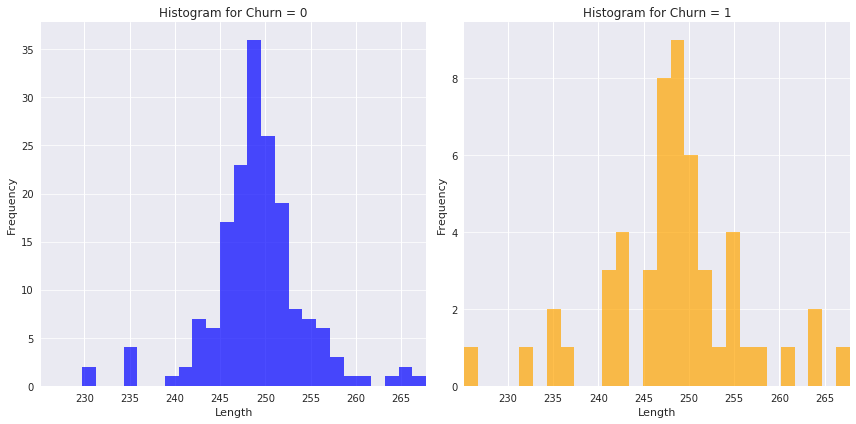

In [42]:
plot_histograms_by_length(df_length, output_file='histograms_by_length.png', bins='auto')

![Histogram of Length]('histograms_by_length.png')

Through the chart above we see that there is not much difference in teeth. The average length is mainly concentrated in the range of 200 to 300 on both churn = 1 and churn = 0 sets.

#### What is the gender of the groups?

In [43]:
# create gender df grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates()
df_gender = df_gender.toPandas()


In [44]:
def plot_gender_distribution_by_churn(df, output_file=None):
    """
    Plots pie charts of gender distribution grouped by churn status 
    and optionally saves the plot to a PNG file.

    This function takes a DataFrame, groups it by the 'churn' column, 
    and plots pie charts showing the proportion of each gender for users 
    with different churn statuses (0 or 1).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing the user activity data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - 'gender': Categorical column representing gender (e.g., 'Male', 'Female').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    Returns:
    --------
    None
        Displays pie chart plots with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        gender_counts = group['gender'].value_counts()  # Count occurrences of each gender
        
        # Plot pie chart
        ax.pie(
            gender_counts, 
            labels=gender_counts.index, 
            autopct='%1.1f%%',  # Show percentage with one decimal place
            startangle=90,      # Rotate start angle for better alignment
            colors=['lightblue', 'pink'] if 'Male' in gender_counts.index else ['pink', 'lightblue'],  # Assign colors
            textprops={'fontsize': 10}  # Adjust text size
        )
        ax.set_title(f'Gender Distribution for Churn = {churn_value}', fontsize=12)  # Add title

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to gender_distribution.png


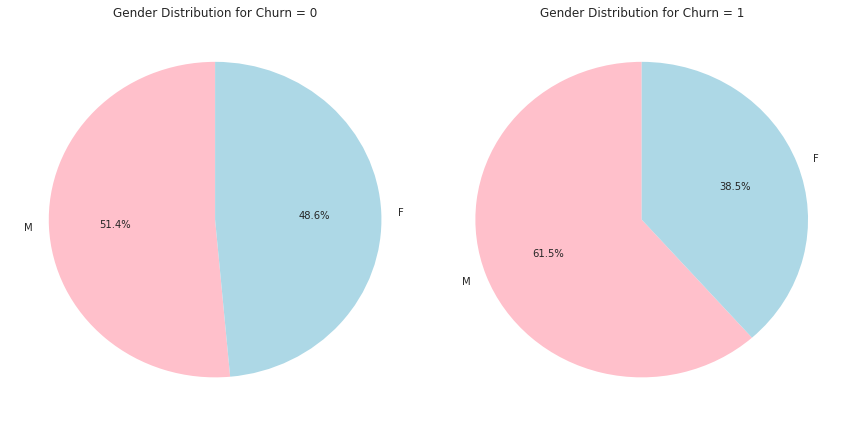

In [45]:
plot_gender_distribution_by_churn(df_gender, output_file='gender_distribution.png')

![Gender Distribution](gender_distribution.png)

The Male ratio in churn = 1 set is quite high while in churn = 0 set it is quite balanced.

#### What is the level of users in each group?

In [46]:
# create gender df grouped by churn and gender
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates()
df_level = df_level.toPandas()
df_level.head()

,userId,churn,level
0,100010,0,free
1,200002,0,paid
2,200002,0,free
3,125,1,free
4,124,0,paid


In [47]:

def plot_level_distribution_by_churn(df, output_file=None):
    """
    Plots pie charts of level distribution grouped by churn status 
    and optionally saves the plot to a PNG file.

    This function takes a DataFrame, groups it by the 'churn' column, 
    and plots pie charts showing the proportion of each level for users 
    with different churn statuses (0 or 1).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing the user activity data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - 'level': Categorical column representing user level (e.g., 'Free', 'Paid').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    Returns:
    --------
    None
        Displays pie chart plots with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        level_counts = group['level'].value_counts()  # Count occurrences of each level
        
        # Plot pie chart
        ax.pie(
            level_counts, 
            labels=level_counts.index, 
            autopct='%1.1f%%',  # Show percentage with one decimal place
            startangle=90,      # Rotate start angle for better alignment
            textprops={'fontsize': 10}  # Adjust text size
        )
        ax.set_title(f'Level Distribution for Churn = {churn_value}', fontsize=12)  # Add title

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to level_distribution.png


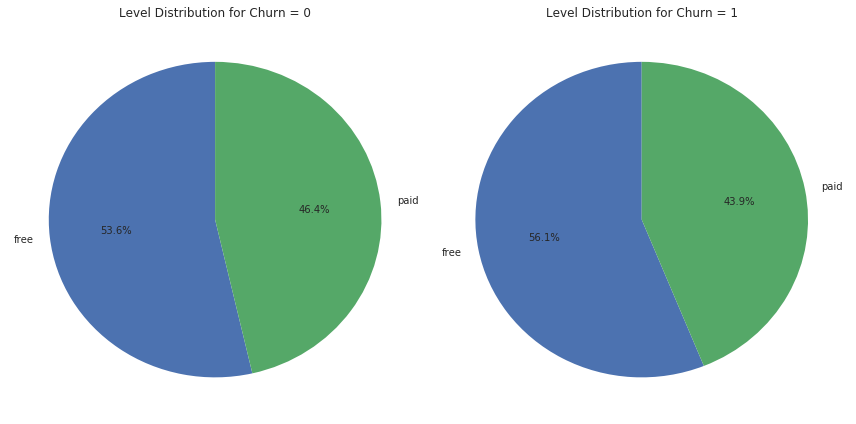

In [48]:
plot_level_distribution_by_churn(df_level, output_file='level_distribution.png')

![Gender Distribution](level_distribution.png)

Free level users have a higher chance of churn = 1

#### How long has the user been a member of each group?

In [49]:
# get datetime from timestamp
get_datetime_str = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
# add datetime_registration to df
df = df.withColumn('datetime_registration', get_datetime_str(df.registration))
df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, datetime_registration='2018-09-27 02:45:40')]

In [50]:
# get datetime from timestamp
get_datetime_str = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
# add datetime_registration to df
df = df.withColumn('datetime_ts', get_datetime_str(df.ts))
df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, datetime_registration='2018-09-27 02:45:40', datetime_ts='2018-11-21 18:12:32')]

Determine the number of days the user is a member

In [51]:
get_duration = udf(lambda x,y: float((x-y)/(1000*60*60*24)))

df = df.withColumn("days_of_membership", get_duration(df.ts, df.registration))
df = df.withColumn("days_of_membership", df["days_of_membership"].cast(IntegerType()))

In [52]:
df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, datetime_registration='2018-09-27 02:45:40', datetime_ts='2018-11-21 18:12:32', days_of_membership=55)]

In [53]:
df_days_of_membership = df.select(['userId', 'churn', 'days_of_membership']).dropDuplicates()

In [54]:
df_days_of_membership = df.toPandas()
df_days_of_membership.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,churn,datetime_registration,datetime_ts,days_of_membership
0,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,187,None,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-09-27 02:45:40,2018-11-21 18:12:32,55
1,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-09-27 02:45:40,2018-11-21 18:12:31,55
2,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-09-27 02:45:40,2018-11-21 18:08:02,55
3,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-09-27 02:45:40,2018-11-21 18:06:07,55
4,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,...,187,None,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,2018-09-27 02:45:40,2018-11-21 18:00:57,55


In [55]:
df_days_of_membership = df_days_of_membership.groupby('userId').agg({'churn': 'max', 'days_of_membership': 'mean'})
df_days_of_membership.shape


(225, 2)

In [56]:

def plot_days_of_membership_histogram(df, column, output_file=None, bin_width=10, xlim_max=None):
    """
    Plots histograms of 'days_of_membership' grouped by churn status 
    and optionally saves the plot to a PNG file.

    This function takes a DataFrame, groups it by the 'churn' column, 
    and plots histograms showing the distribution of 'days_of_membership'
    for users with different churn statuses (0 or 1).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing user membership data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - column: Continuous numeric column to plot (e.g., 'days_of_membership').

    column : str
        The column name to plot as histogram (e.g., 'days_of_membership').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    bin_width : int, optional
        The width of each bin in the histogram. Default is 10.

    xlim_max : int, optional
        The maximum limit for the x-axis. If None, it is set based on the column's maximum value.

    Returns:
    --------
    None
        Displays histogram plots with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Automatically calculate bin edges
    bin_edges = np.arange(0, df[column].max() + bin_width, bin_width)

    # Set x-axis limit if not provided
    if xlim_max is None:
        xlim_max = df[column].max()

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group[column], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}')  # Title for each subplot
        ax.set_xlabel('Days of Membership')                   # X-axis label
        ax.set_ylabel('Frequency')                            # Y-axis label
        ax.set_xlim(0, xlim_max)                              # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)                         # Add gridlines for clarity

        # Add labels to each bar
        for count, bin_left, patch in zip(counts, bins[:-1], patches):
            x_position = bin_left + (bins[1] - bins[0]) / 2

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to membership_distribution.png


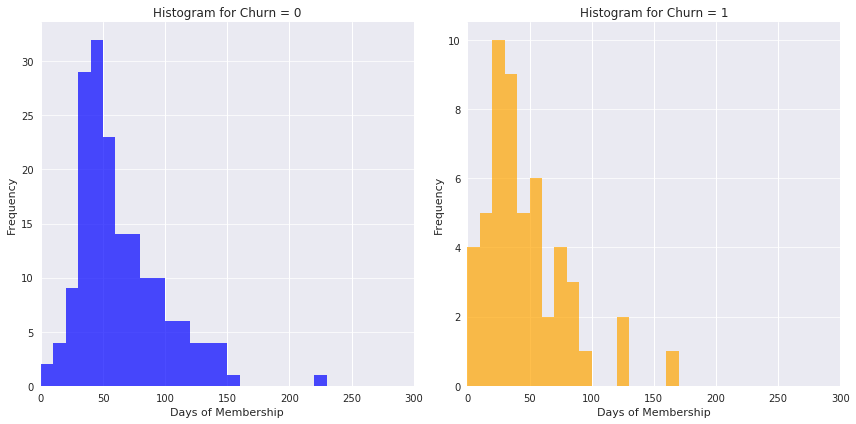

In [57]:
plot_days_of_membership_histogram(
    df_days_of_membership, 
    column='days_of_membership', 
    output_file='membership_distribution.png', 
    bin_width=10, 
    xlim_max=300
)


!['Days of Membership']('membership_distribution.png')
The average number of days a user is a membership user churned is usually less than 100 days.

#### How many user actions are there in each group?

In [58]:
df_user_action = df.select(['userId', 'churn', 'sessionId', 'itemInSession']).dropDuplicates().toPandas()
df_user_action = df_user_action.groupby(['userId', 'sessionId']).agg({'churn': 'max', 'itemInSession': 'count'}).reset_index()
df_user_action = df_user_action.groupby(['userId']).agg({'churn': 'max', 'itemInSession': 'mean'}).reset_index()

In [59]:
df_user_action.columns = ['userId',	'churn','avg_number_actions']
df_user_action.head()

,userId,churn,avg_number_actions
0,10,0,132.500000
1,100,0,91.828571
2,100001,1,46.750000
3,100002,0,54.500000
4,100003,1,39.000000


In [60]:
def plot_avg_actions_histogram(df, column, output_file=None, bin_width=10, xlim_max=None):
    """
    Plots histograms of a specified column grouped by churn status
    and optionally saves the plot to a PNG file.

    This function groups data by the 'churn' column and plots histograms
    showing the distribution of the specified column for users with different churn statuses.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing user action data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - column: Continuous numeric column to plot (e.g., 'avg_number_actions').

    column : str
        The column name to plot as histogram (e.g., 'avg_number_actions').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    bin_width : int, optional
        The width of each bin in the histogram. Default is 10.

    xlim_max : int, optional
        The maximum limit for the x-axis. If None, it is set based on the column's maximum value.

    Returns:
    --------
    None
        Displays histogram plots with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Automatically calculate bin edges
    bin_edges = np.arange(0, df[column].max() + bin_width, bin_width)

    # Set x-axis limit if not provided
    if xlim_max is None:
        xlim_max = df[column].max()

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group[column], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}', fontsize=12)  # Title for each subplot
        ax.set_xlabel('Average Number of Actions per Session', fontsize=10)  # X-axis label
        ax.set_ylabel('Frequency', fontsize=10)  # Y-axis label
        ax.set_xlim(0, xlim_max)  # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)  # Add gridlines for clarity

        # Add labels to each bar (optional)
        for count, bin_left, patch in zip(counts, bins[:-1], patches):
            x_position = bin_left + (bins[1] - bins[0]) / 2

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to avg_actions_distribution.png


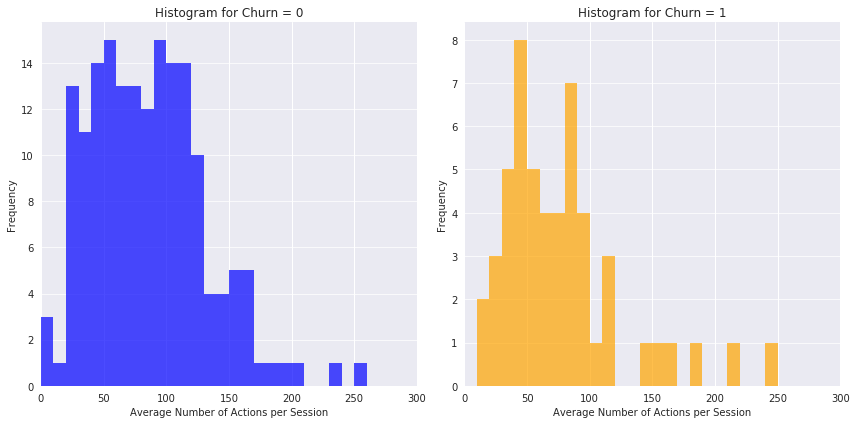

In [61]:
plot_avg_actions_histogram(
    df_user_action, 
    column='avg_number_actions', 
    output_file='avg_actions_distribution.png', 
    bin_width=10, 
    xlim_max=300
)


![Average Number of Actions per Session](avg_actions_distribution.png)
Average number of actions of churned users = 1 mainly concentrated under 100 actions per session

#### How many artists are users interested in each session?

In [62]:
df.filter(df['artist'] != "NaN").select(['userId', 'churn', 'sessionId', 'artist']).dropDuplicates().show()

+------+-----+---------+--------------------+
|userId|churn|sessionId|              artist|
+------+-----+---------+--------------------+
|100010|    0|      187|          Lily Allen|
|100010|    0|      187|          John Waite|
|100010|    0|      187|             Hermano|
|100010|    0|      187|            Hot Chip|
|100010|    0|      187|              Eminem|
|100010|    0|      187|          The Police|
|100010|    0|      187|               Ke$ha|
|100010|    0|      187|        Gwen Stefani|
|100010|    0|      187|           DJ Khaled|
|100010|    0|      187|      Kelly Clarkson|
|100010|    0|      187|           Bob James|
|100010|    0|      187|Nick Cave & The B...|
|100010|    0|      187|                T.I.|
|100010|    0|      187|          Sev Statik|
|100010|    0|      187|       Drowning Pool|
|100010|    0|      187|Usher featuring B...|
|100010|    0|      187|          Kanye West|
|100010|    0|      187|      Hit The Lights|
|100010|    0|      187|         H

In [63]:
df_user_artist = df.filter(df['artist'] != "NaN").select(['userId', 'churn', 'sessionId', 'artist']).dropDuplicates().toPandas()
df_user_artist = df_user_artist.groupby(['userId', 'sessionId']).agg({'churn': 'max', 'artist': 'count'}).reset_index()
df_user_artist = df_user_artist.groupby(['userId']).agg({'churn': 'max', 'artist': 'mean'}).reset_index()
df_user_artist.columns = ['userId',	'churn','avg_number_artist']
df_user_artist.head()

,userId,churn,avg_number_artist
0,10,0,104.666667
1,100,0,74.588235
2,100001,1,33.000000
3,100002,0,46.500000
4,100003,1,25.000000


In [64]:
def plot_avg_artist_histogram(df, column, output_file=None, bin_width=10, xlim_max=None):
    """
    Plots histograms of a specified column grouped by churn status
    and optionally saves the plot to a PNG file.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing user artist data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - column: Continuous numeric column to plot (e.g., 'avg_number_artist').

    column : str
        The column name to plot as histogram (e.g., 'avg_number_artist').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    bin_width : int, optional
        The width of each bin in the histogram. Default is 10.

    xlim_max : int, optional
        The maximum limit for the x-axis. If None, it is set based on the column's maximum value.

    Returns:
    --------
    None
        Displays histogram plots with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Automatically calculate bin edges
    bin_edges = np.arange(0, df[column].max() + bin_width, bin_width)

    # Set x-axis limit if not provided
    if xlim_max is None:
        xlim_max = df[column].max()

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group[column], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}', fontsize=12)  # Title for each subplot
        ax.set_xlabel('Average Number of Artists per Session', fontsize=10)  # X-axis label
        ax.set_ylabel('Frequency', fontsize=10)  # Y-axis label
        ax.set_xlim(0, xlim_max)  # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)  # Add gridlines for clarity

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to avg_artist_distribution.png


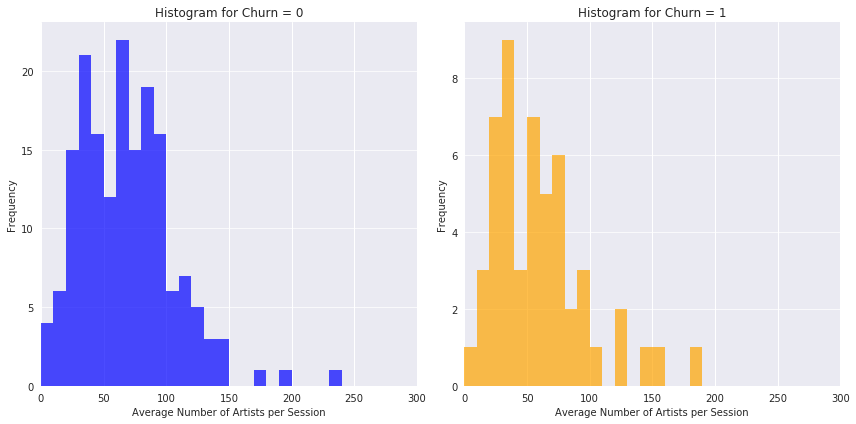

In [65]:
plot_avg_artist_histogram(
    df_user_artist, 
    column='avg_number_artist', 
    output_file='avg_artist_distribution.png', 
    bin_width=10, 
    xlim_max=300
)


![Average Number of Artists per Session](avg_artist_distribution.png)
Average number of artists listened to per churn group = 1 mostly less than 100 artists per session

#### What are the user's Thumbs Down/Thumbs Up?

In [66]:
df_like_or_dislike = df.filter((df['page'] == "Thumbs Up")|(df['page'] == "Thumbs Down")).select(['userId', 'churn', 'sessionId', 'page']).dropDuplicates().toPandas()

In [67]:
df_like_or_dislike.head()

,userId,churn,sessionId,page
0,100010,0,187,Thumbs Up
1,100010,0,187,Thumbs Down
2,100010,0,174,Thumbs Up
3,100010,0,174,Thumbs Down
4,100010,0,133,Thumbs Up


In [68]:
df_like_or_dislike = df_like_or_dislike.groupby(['userId','churn','page']).count().reset_index()
df_like_or_dislike


,userId,churn,page,sessionId
0,10,0,Thumbs Down,1
1,10,0,Thumbs Up,6
2,100,0,Thumbs Down,11
3,100,0,Thumbs Up,30
4,100001,1,Thumbs Down,2
5,100001,1,Thumbs Up,3
6,100002,0,Thumbs Up,2
7,100003,1,Thumbs Up,1
8,100004,0,Thumbs Down,7
9,100004,0,Thumbs Up,13


In [69]:
df_like_or_dislike = df_like_or_dislike.pivot_table(index=['userId', 'churn'], columns='page', values='sessionId', aggfunc='sum', fill_value=0).reset_index()

In [70]:
df_like_or_dislike['rate'] = (df_like_or_dislike['Thumbs Up']+1)/(df_like_or_dislike['Thumbs Down']+1)
df_like_or_dislike.head()

page,userId,churn,Thumbs Down,Thumbs Up,rate
0,10,0,1,6,3.500000
1,100,0,11,30,2.583333
2,100001,1,2,3,1.333333
3,100002,0,0,2,3.000000
4,100003,1,0,1,2.000000


In [71]:
# Group by churn
grouped = df_like_or_dislike.groupby('churn').mean()
grouped.head()

page,Thumbs Down,Thumbs Up,rate
churn,,,
0,6.341176,11.758824,1.921603
1,4.921569,7.686275,1.569598


The number of likes and dislikes churned is quite low, the like/dislike ratio is also lower than churn=0

#### Does the operating system have any impact on churn?

In [72]:
df_userAgent = df.select(['userId', 'churn', 'sessionId', 'userAgent']).dropDuplicates().toPandas()
df_userAgent.head()

,userId,churn,sessionId,userAgent
0,100010,0,187,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."
1,100010,0,174,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."
2,100010,0,133,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."
3,100010,0,118,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."
4,100010,0,113,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."


In [73]:
df_userAgent.userAgent.value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                265
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        236
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       196
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     174
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     163
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"                                156
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"       

In [74]:
# OS keywords
os_keywords = {
    "Windows": ["Windows NT"],
    "Mac": ["Macintosh"],
    "Linux": ["X11", "Linux"],
    "iOS": ["iPhone", "iPad"],
    "Other": []  # Default category for unmatched cases
}

# Function to classify OS
def classify_os(user_agent):
    for os, keywords in os_keywords.items():
        if any(keyword in user_agent for keyword in keywords):
            return os
    return "Other"

# Add a new column for OS classification
df_userAgent["OS"] = df_userAgent["userAgent"].apply(classify_os)

# Group by OS and sum the counts
os_distribution = df_userAgent.groupby(["churn","OS"])['userId'].count().reset_index()



In [75]:
os_distribution.head()

,churn,OS,userId
0,0,Linux,97
1,0,Mac,936
2,0,Windows,1352
3,0,iOS,254
4,1,Linux,28


In [76]:
def plot_os_distribution_pie(df, column_userid, column_os, output_file=None):
    """
    Plots pie charts showing OS distribution grouped by churn status.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing OS distribution data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - column_userid: Column representing counts or weights for each OS.
        - column_os: Column representing the OS categories.

    column_userid : str
        The column name representing user counts or weights (e.g., 'userId').

    column_os : str
        The column name representing OS categories (e.g., 'OS').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    Returns:
    --------
    None
        Displays pie charts with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Group data by OS and calculate the sum of users for each OS
        os_counts = group.groupby(column_os)[column_userid].sum()

        # Plot pie chart
        ax.pie(
            os_counts, 
            labels=os_counts.index, 
            autopct='%1.1f%%',  # Show percentage with one decimal place
            startangle=90,      # Rotate start angle for better alignment
            textprops={'fontsize': 10}  # Adjust text size
        )
        ax.set_title(f'OS Distribution for Churn = {churn_value}', fontsize=12)  # Add title

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to os_distribution_pie.png


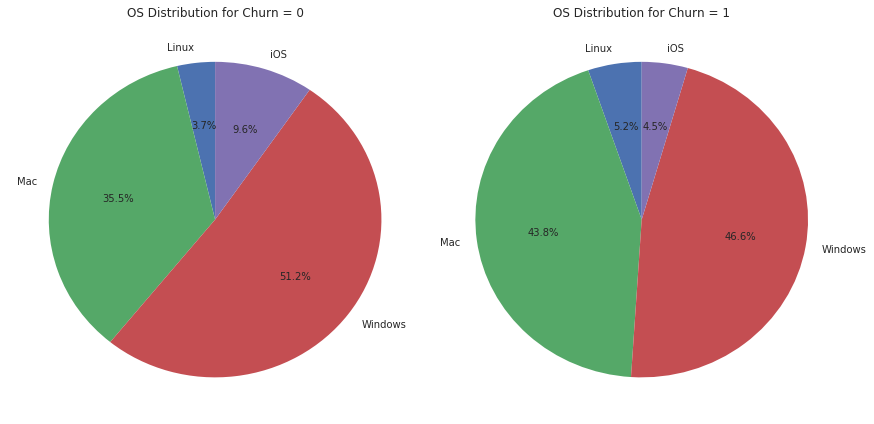

In [77]:
plot_os_distribution_pie(
    os_distribution, 
    column_userid='userId', 
    column_os='OS', 
    output_file='os_distribution_pie.png'
)


![OS Distribution](os_distribution_pie.png)
MacOs and Windows are the majority operating systems.

#### What is the churn rate if a user has many friends?

In [78]:
df_add_friends = df.filter((df['page'] == "Add Friend")).select(['userId', 'churn', 'sessionId', 'page']).dropDuplicates().toPandas()
df_add_friends.head()

,userId,churn,sessionId,page
0,100010,0,133,Add Friend
1,100010,0,118,Add Friend
2,100010,0,113,Add Friend
3,200002,0,163,Add Friend
4,200002,0,44,Add Friend


In [79]:
df_add_friends = df_add_friends.groupby('userId').agg({'churn': 'max', 'page': 'count'})

In [80]:
df_add_friends.head()

,churn,page
userId,,
10,0,6
100,0,20
100001,1,2
100002,0,1
100004,0,9


In [81]:
def plot_add_friends_histogram(df, column_page, bin_width=10, max_x=300, output_file=None):
    """
    Plots histograms showing the distribution of 'Add friends' actions grouped by churn status.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing user actions data. It should have the following columns:
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - column_page: Column representing the number of 'Add friends' actions.

    column_page : str
        The column name representing the 'Add friends' data (e.g., 'page').

    bin_width : int, optional (default=10)
        The width of bins in the histogram.

    max_x : int, optional (default=300)
        The maximum value for the x-axis (used for consistent scaling).

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    Returns:
    --------
    None
        Displays histograms with subplots for each churn status and optionally saves it to a file.
    """
    # Group by churn
    grouped = df.groupby('churn')

    # Define bin edges
    bin_edges = np.arange(0, max_x + bin_width, bin_width)

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group[column_page], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}', fontsize=12)  # Title for each subplot
        ax.set_xlabel('Add friends actions')                              # X-axis label
        ax.set_ylabel('Frequency')                                        # Y-axis label
        ax.set_xlim(0, max_x)                                             # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)                                     # Add gridlines for clarity
        # Add labels to each bar
        for count, bin_left, patch in zip(counts, bins[:-1], patches):
            # Calculate the position for the label
            if count > 0:  # Add labels only for non-zero counts
                x_position = bin_left + (bins[1] - bins[0]) / 2
                y_position = count + 10  # Offset for better readability
                ax.text(
                    x_position, y_position, f'{int(count)}', 
                    ha='center', fontsize=8, color='black', alpha=0.8
                )

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()


Figure saved to add_friends_histogram.png


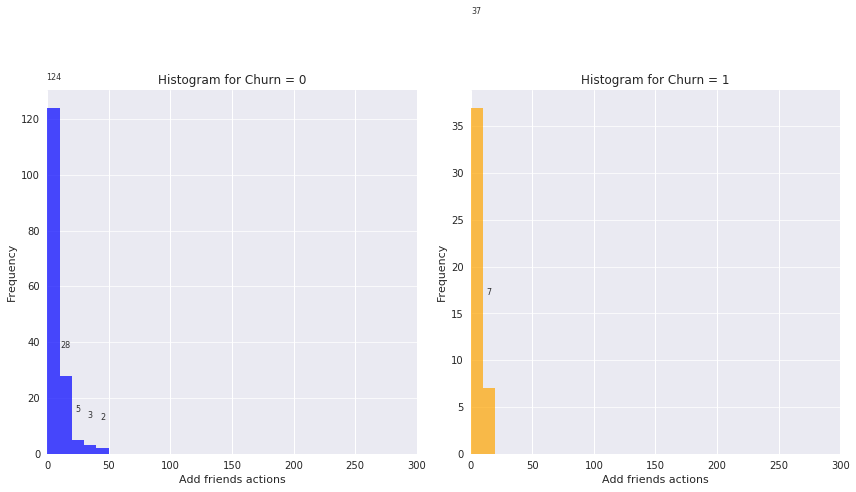

In [82]:
plot_add_friends_histogram(
    df_add_friends, 
    column_page='page', 
    bin_width=10, 
    max_x=300, 
    output_file='add_friends_histogram.png'
)


!['Add friends actions'](add_friends_histogram.png)
The number of added friends of each user is quite small in churn = 1 set.

#### What if a user has multiple Add to Playlist actions?

In [83]:
df_add_playlist = df.filter((df['page'] == "Add to Playlist")).select(['userId', 'churn', 'sessionId', 'page']).dropDuplicates().toPandas()
df_add_playlist.head()

,userId,churn,sessionId,page
0,100010,0,187,Add to Playlist
1,100010,0,174,Add to Playlist
2,100010,0,133,Add to Playlist
3,100010,0,118,Add to Playlist
4,100010,0,113,Add to Playlist


In [84]:
def plot_histograms_by_churn(df, output_file=None, bins='auto'):
    """
    Plots histograms of the 'Add to Playlist' action grouped by 'churn' status 
    and optionally saves to a PNG file.

    This function takes a DataFrame, groups it by the 'churn' column, 
    and plots histograms for the count of 'Add to Playlist' actions 
    for users with different churn statuses (0 or 1).

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing the user activity data. It should have the following columns:
        - 'userId': Unique identifier for each user.
        - 'churn': Binary column indicating churn status (0 = not churned, 1 = churned).
        - 'page': Represents the activity being counted (e.g., 'Add to Playlist').

    output_file : str, optional
        The file path where the plot will be saved as a PNG file. If None, the plot will only be displayed.

    bins : int, str, or numpy array, optional
        The bin strategy or number of bins to use for the histograms. 
        Default is 'auto', which automatically determines bin edges using numpy.histogram_bin_edges.

    Returns:
    --------
    None
        Displays a histogram plot with subplots for each churn status and optionally saves it to a file.
    """
    # Aggregate by userId
    df_agg = df.groupby('userId').agg({'churn': 'max', 'page': 'count'})
    
    # Group by churn
    grouped = df_agg.groupby('churn')

    # Determine bin edges based on the entire dataset
    all_data = df_agg['page']
    _, bin_edges = np.histogram(all_data, bins=bins)

    # Create a figure with 2 subplots side by side
    fig = plt.figure(figsize=(12, 6))

    # Iterate through each group and plot on separate axes
    for i, (churn_value, group) in enumerate(grouped):
        ax = fig.add_subplot(1, 2, i + 1)  # Create a subplot (1 row, 2 columns, index i+1)
        
        # Plot histogram
        counts, bins, patches = ax.hist(
            group['page'], 
            bins=bin_edges, 
            alpha=0.7, 
            color='blue' if churn_value == 0 else 'orange'
        )
        ax.set_title(f'Histogram for Churn = {churn_value}')  # Title for each subplot
        ax.set_xlabel('Add to Playlist')                     # X-axis label
        ax.set_ylabel('Frequency')                           # Y-axis label
        ax.set_xlim(bin_edges[0], bin_edges[-1])             # Set x-axis limit
        ax.grid(axis='y', alpha=0.75)                        # Add gridlines for clarity

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to file if output_file is specified
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
        print(f"Figure saved to {output_file}")

    # Display the plot
    plt.show()

Figure saved to histograms_add_to_playlist_by_churn.png


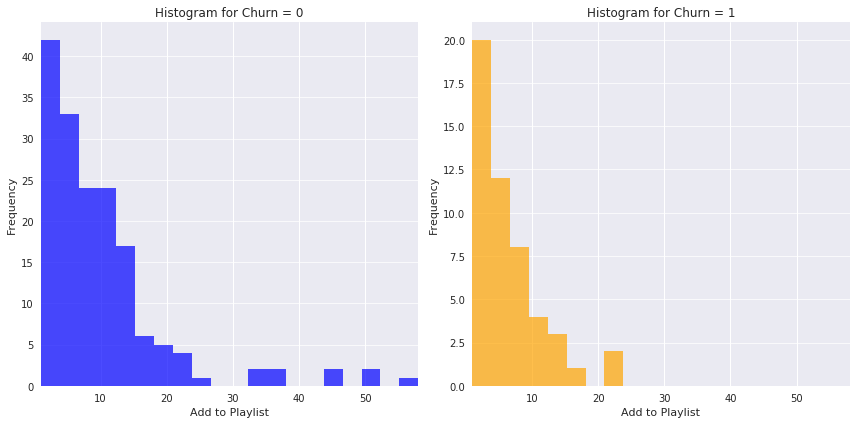

In [85]:
plot_histograms_by_churn(df_add_playlist, output_file='histograms_add_to_playlist_by_churn.png', bins=20)